In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import shapely as shp
from datetime import datetime

from itertools import compress

# make sure we are at the top of the repo
wd = subprocess.check_output('git rev-parse --show-toplevel', shell = True)
os.chdir(wd[:-1]) #-1 removes \n

In [2]:
# read in nyc census block shapefiles
nycshp = gp.read_file('data/nycb2010_16c/nycb2010.shp')

# set up cooridnate system
nycshp = nycshp.to_crs(epsg=4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet

subway = pd.read_csv('data/subway.csv')

In [3]:
nycshp.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,"POLYGON ((-74.07920577013249 40.643430783779, ..."
1,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,POLYGON ((-74.07061992438021 40.61085506708748...
2,50027001000,5,Staten Island,1000,002700,150406.784296,1703.381058,POLYGON ((-74.07524403976554 40.62600632405744...
3,50040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,"POLYGON ((-74.0870879968983 40.61116883127258,..."
4,50064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,POLYGON ((-74.07643744511995 40.60100160658919...


In [4]:
#get list of new citibike stations
# read in last available calendar year of citibike data
citi = pd.DataFrame()
for m in ['citibike_201509.csv', 
         'citibike_201510.csv',
         'citibike_201511.csv',
         'citibike_201512.csv',
         'citibike_201601.csv',
         'citibike_201602.csv',
         'citibike_201603.csv',
         'citibike_201604.csv',
         'citibike_201605.csv',
         'citibike_201606.csv',
         'citibike_201607.csv',
         'citibike_201608.csv']:
    citinew = pd.read_csv('data/'+m)
    citi = citi.append(citinew, ignore_index = True)


In [5]:
# keep only stations not available at the start of 2014
jan = pd.read_csv('data/citibike_201401.csv')
orig_stations = jan['start station id'].unique()

citi = citi[~np.in1d(citi['start station id'], orig_stations)]

In [6]:
len(citi['start station id'].unique())

284

In [7]:
# keep only subscribers
citi = citi[citi['usertype'] == 'Subscriber']

In [8]:
citi_stations = pd.DataFrame()
for i in citi['start station id'].unique():
    citi_stations_unique = citi[citi['start station id'] == i].iloc[0:1,]
    citi_stations = citi_stations.append(citi_stations_unique, ignore_index = True)

In [9]:
citi_stations.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,715,9/1/2015 00:01:06,9/1/2015 00:13:02,3075,Division Ave & Marcy Ave,40.707087,-73.957968,364,Lafayette Ave & Classon Ave,40.689004,-73.960239,19355,Subscriber,1984.0,1
1,1247,9/1/2015 00:03:01,9/1/2015 00:23:49,3133,E 67 St & Lexington Ave,40.767343,-73.964859,334,W 20 St & 7 Ave,40.742388,-73.997262,20131,Subscriber,1978.0,2
2,236,9/1/2015 00:05:44,9/1/2015 00:09:41,3118,McGuinness Blvd & Eagle St,40.735550,-73.952840,3113,Greenpoint Ave & Manhattan Ave,40.730260,-73.953940,17107,Subscriber,1979.0,1
3,362,9/1/2015 00:12:48,9/1/2015 00:18:50,3110,Meserole Ave & Manhattan Ave,40.727086,-73.952991,3115,India St & Manhattan Ave,40.732322,-73.955086,18257,Subscriber,1978.0,1
4,225,9/1/2015 00:12:52,9/1/2015 00:16:37,3093,N 6 St & Bedford Ave,40.717452,-73.958509,481,S 3 St & Bedford Ave,40.712605,-73.962644,23001,Subscriber,1989.0,1


In [10]:
#Convert starttime to timpstamp format
citi_stations['timestamp'] = pd.to_datetime(citi_stations["starttime"])

In [11]:
len(citi_stations)

283

In [12]:
(citi_stations['timestamp'] > '2014-02-01 00:00:00').sum()

283

In [13]:
citi_stations_new = citi_stations[citi_stations['timestamp'] > '2014-02-01 00:00:00']
citi_stations_new.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,timestamp
0,715,9/1/2015 00:01:06,9/1/2015 00:13:02,3075,Division Ave & Marcy Ave,40.707087,-73.957968,364,Lafayette Ave & Classon Ave,40.689004,-73.960239,19355,Subscriber,1984.0,1,2015-09-01 00:01:06
1,1247,9/1/2015 00:03:01,9/1/2015 00:23:49,3133,E 67 St & Lexington Ave,40.767343,-73.964859,334,W 20 St & 7 Ave,40.742388,-73.997262,20131,Subscriber,1978.0,2,2015-09-01 00:03:01
2,236,9/1/2015 00:05:44,9/1/2015 00:09:41,3118,McGuinness Blvd & Eagle St,40.735550,-73.952840,3113,Greenpoint Ave & Manhattan Ave,40.730260,-73.953940,17107,Subscriber,1979.0,1,2015-09-01 00:05:44
3,362,9/1/2015 00:12:48,9/1/2015 00:18:50,3110,Meserole Ave & Manhattan Ave,40.727086,-73.952991,3115,India St & Manhattan Ave,40.732322,-73.955086,18257,Subscriber,1978.0,1,2015-09-01 00:12:48
4,225,9/1/2015 00:12:52,9/1/2015 00:16:37,3093,N 6 St & Bedford Ave,40.717452,-73.958509,481,S 3 St & Bedford Ave,40.712605,-73.962644,23001,Subscriber,1989.0,1,2015-09-01 00:12:52


In [14]:
citi_stations_new = citi_stations_new[["timestamp", "start station id", "start station name", "start station latitude", "start station longitude"]]
citi_stations_new.columns = ['timestamp', 'station_id', 'name', 'lat', 'lon']

# combine lat and lon to one column
citi_stations_new['lonlat']=zip(citi_stations_new.lon, citi_stations_new.lat)

# Create Point Geometry for based on lonlat column
citi_stations_new['geometry']=citi_stations_new[['lonlat']].applymap(lambda x:shp.geometry.Point(x))
citi_stations_new.head()

,timestamp,station_id,name,lat,lon,lonlat,geometry
0,2015-09-01 00:01:06,3075,Division Ave & Marcy Ave,40.707087,-73.957968,"(-73.95796783, 40.70708701)",POINT (-73.95796783 40.70708701)
1,2015-09-01 00:03:01,3133,E 67 St & Lexington Ave,40.767343,-73.964859,"(-73.9648586512, 40.7673425914)",POINT (-73.96485865116121 40.76734259143217)
2,2015-09-01 00:05:44,3118,McGuinness Blvd & Eagle St,40.735550,-73.952840,"(-73.95284, 40.73555)",POINT (-73.95284000000001 40.73555)
3,2015-09-01 00:12:48,3110,Meserole Ave & Manhattan Ave,40.727086,-73.952991,"(-73.95299117, 40.72708584)",POINT (-73.95299117 40.72708584)
4,2015-09-01 00:12:52,3093,N 6 St & Bedford Ave,40.717452,-73.958509,"(-73.95850939, 40.71745169)",POINT (-73.95850939 40.71745169)


In [15]:
# dataframe for rides per station
citi_rides = citi[['start station id', 'tripduration']] # keep duration because we need a column to count with
citi_rides.columns = ['station_id','n_rides']
citi_rides = citi_rides.groupby('station_id').count()

In [16]:
# merge number of rides into station detail table
citi_stations_new = citi_stations_new.merge(citi_rides, how = 'left', left_on = 'station_id', right_index = True)
citi_stations_new = citi_stations_new[["timestamp", "station_id", "geometry", "n_rides"]]

In [17]:
# buffer around each point
citi_stations_new = gp.GeoDataFrame(citi_stations_new, geometry = 'geometry')
citi_stations_new.crs = {'init' :'epsg:4326'}
citi_stations_new = citi_stations_new.to_crs(epsg=2263) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
nycshp = nycshp.to_crs(epsg=2263)

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['compress', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


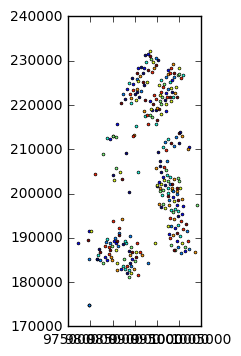

In [18]:
import pylab as pl
%pylab inline

citi_stations_new.plot()

## add in census block demographics data

In [19]:
nycshp['BCTCB2010'] = [i[1:] for i in nycshp['BCTCB2010']]
nycshp.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,0009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,"POLYGON ((962269.1260375977 173705.5001951929,..."
1,0020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,"POLYGON ((964642.2676391613 161835.2652098391,..."
2,0027001000,5,Staten Island,1000,002700,150406.784296,1703.381058,"POLYGON ((963363.1166381794 167356.3334471463,..."
3,0040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,"POLYGON ((960069.9965820312 161953.6936156093,..."
4,0064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,"POLYGON ((963023.8917846683 158246.7522093526,..."


In [20]:
nycshp.BCTCB2010[nycshp.BoroName == 'Staten Island'] = '36085' + nycshp.BCTCB2010[nycshp.BoroName == 'Staten Island']
nycshp.BCTCB2010[nycshp.BoroName == 'Manhattan'] = '36061' + nycshp.BCTCB2010[nycshp.BoroName == 'Manhattan']
nycshp.BCTCB2010[nycshp.BoroName == 'Queens'] = '36081' + nycshp.BCTCB2010[nycshp.BoroName == 'Queens']
nycshp.BCTCB2010[nycshp.BoroName == 'Brooklyn'] = '36047' + nycshp.BCTCB2010[nycshp.BoroName == 'Brooklyn']
nycshp.BCTCB2010[nycshp.BoroName == 'Bronx'] = '36005' + nycshp.BCTCB2010[nycshp.BoroName == 'Bronx']


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
# check for each citibike stations to see what CB they belong to
a = []
citi_stations_new['tracts'] = 0
for i in range(len(citi_stations_new)):
    # includes stations not in Manhattan, return 0 for CB. 
    try: 
        a.append([k for k in nycshp[nycshp.geometry.intersects(citi_stations_new.iloc[i].geometry.buffer(150))].BCTCB2010])
    except: 
        a.append(0)
    print '\r',"%",str((i+1)*100./len(citi_stations_new))[:4],
citi_stations_new['tracts']=a
citi_stations_new = citi_stations_new.reindex()

% 100.


In [22]:
citi_stations_new = citi_stations_new[["station_id", "n_rides", "geometry", "tracts"]]
citi_stations_new.tail()

,station_id,n_rides,geometry,tracts
278,3386,10,POINT (984511.5255380345 187368.1825631277),"[360470065002000, 360470065002001, 36047006500..."
279,3340,10,POINT (981456.8041949553 185316.5515138066),"[360470053004001, 360470053004002, 36047005300..."
280,3326,3,POINT (983709.931985212 184956.6589112134),"[360470085003000, 360470053001022, 36047005300..."
281,3353,8,POINT (979776.1930346335 185118.9723933369),"[360470053003003, 360470053001014]"
282,3342,1,POINT (981625.6883271895 186208.1906875979),"[360470085001000, 360470053002007, 36047005900..."


In [23]:
df = gp.read_file('data/cb_dist/cb_dist_all_nyc.shp')

In [24]:
demo = pd.read_csv('data/demo.csv')
df.tail(10)

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,dist_tohom,dist_towor,geometry,residents,workers
20896,360810006001003,4,Queens,1003,000600,159213.793766,1788.364426,4.590714,6.182529,"POLYGON ((1022946.834228517 188809.5380369891,...",73,5
20897,360810008002005,4,Queens,2005,000800,167035.873429,1822.279534,2.303593,5.757164,"POLYGON ((1023190.786987306 188905.8498045706,...",62,5
20898,360610243021005,1,Manhattan,1005,024302,283063.278099,2468.026395,4.061102,5.156696,"POLYGON ((1001755.348388672 241636.4550291704,...",455,26
20899,360810471001002,4,Queens,1002,047100,149379.347933,1644.308065,5.151350,4.762213,"POLYGON ((1018715.723999023 209626.3394285868,...",112,1
20900,360810471001005,4,Queens,1005,047100,147595.350818,1668.283412,3.349474,4.674031,"POLYGON ((1018345.718627932 209277.4714476391,...",403,14
20901,360050216023002,2,Bronx,3002,021602,224172.113792,2446.404530,5.468028,6.163652,"POLYGON ((1022728.471984864 244951.2739989016,...",316,66
20902,360050216022001,2,Bronx,2001,021602,146869.945755,1877.106694,5.377462,6.431716,"POLYGON ((1022678.206420899 244466.9444090589,...",165,18
20903,360050216024000,2,Bronx,4000,021602,324298.032947,3013.710468,5.122460,7.602267,"POLYGON ((1022565.290222168 244493.1238524288,...",295,7
20904,360810086001014,4,Queens,1014,008600,167489.726871,1850.958176,5.311830,5.162866,"POLYGON ((1028295.05999756 185832.5723997795, ...",30,2
20905,360810086002005,4,Queens,2005,008600,180746.889134,1909.003325,3.612624,4.883463,"POLYGON ((1028386.265441894 185586.3686033974,...",32,16


In [25]:
demo.head()

,geoid,pop,bike,commute_time,income_pc,no_vehicle_rent,no_vehicle_own
0,360594144003,870,0,312,8291.0,97,0
1,360594141002,1569,0,674,24402.0,0,0
2,360594136001,965,0,428,31416.0,0,25
3,360594142024,1028,0,456,20567.0,60,0
4,360594142022,1197,0,621,16936.0,41,0


In [26]:
df['BCTCB2010'] = df['BCTCB2010'].astype('int')
df['geoid'] = [i[0:-3] for i in df['BCTCB2010'].astype('str')]
df = df.dissolve(by = 'geoid', aggfunc = 'mean', as_index = False)
df.head()

,geoid,geometry,BCTCB2010,Shape_Area,Shape_Leng,dist_tohom,dist_towor,residents,workers
0,360050002001,(POLYGON ((1022729.262390137 235476.9921995869...,3.600500e+14,165502.387824,1902.630188,1.689186,5.015495,38.000000,4.500000
1,360050002002,(POLYGON ((1024075.043823242 234930.1988035945...,3.600500e+14,151808.843054,1804.746075,2.009876,4.787413,42.666667,4.333333
2,360050002003,(POLYGON ((1023807.029235841 233647.6192137522...,3.600500e+14,116814.153846,1303.183315,2.641470,4.547958,17.800000,5.000000
3,360050004001,"POLYGON ((1024174.505615234 234947.731396367, ...",3.600500e+14,188559.140013,2020.183073,7.964882,6.732080,216.000000,4.000000
4,360050004002,"POLYGON ((1024604.209411622 234226.9358031033,...",3.600500e+14,228050.083161,2126.865002,4.454643,5.820165,54.000000,12.666667


In [27]:
# get station demographics and distance
citi_demo = pd.DataFrame()
for i in range(len(citi_stations_new)):
    dists = transpose(pd.DataFrame(df[np.in1d(df.geoid, [j[0:-3] for j in citi_stations_new.tracts.iloc[i]])].mean()))
    dists.index = [citi_stations_new.station_id.iloc[i]]
    dems = transpose(pd.DataFrame(demo[np.in1d(demo.geoid.astype('str'), [j[0:-3] for j in citi_stations_new.tracts.iloc[i]])].mean()))
    dems.index = [citi_stations_new.station_id.iloc[i]]
    citi_new = dists.merge(dems, left_index = True, right_index = True)
    citi_demo = citi_demo.append(citi_new[['bike','commute_time','dist_tohom','dist_towor',\
                                           'income_pc','no_vehicle_own','no_vehicle_rent','pop','workers', 'residents']])

In [28]:
citi_demo = citi_demo.dropna()
citi_demo.tail()

,bike,commute_time,dist_tohom,dist_towor,income_pc,no_vehicle_own,no_vehicle_rent,pop,workers,residents
3386,0.000000,258.000000,5.057410,4.406059,65026.500000,36.000000,138.500000,501.500000,29.000000,189.000000
3340,22.000000,555.500000,5.064736,3.399801,29660.500000,5.000000,625.500000,2215.000000,12.700000,172.100000
3326,3.333333,396.666667,4.032270,3.408609,25993.666667,6.666667,454.000000,1372.000000,116.740741,57.555556
3353,5.000000,185.000000,6.069745,4.118496,38910.000000,4.500000,68.500000,370.000000,152.111111,27.333333
3342,34.666667,590.666667,5.379034,3.704642,26435.000000,9.000000,510.666667,1921.333333,53.678571,137.392857


In [29]:
df.head()

,geoid,geometry,BCTCB2010,Shape_Area,Shape_Leng,dist_tohom,dist_towor,residents,workers
0,360050002001,(POLYGON ((1022729.262390137 235476.9921995869...,3.600500e+14,165502.387824,1902.630188,1.689186,5.015495,38.000000,4.500000
1,360050002002,(POLYGON ((1024075.043823242 234930.1988035945...,3.600500e+14,151808.843054,1804.746075,2.009876,4.787413,42.666667,4.333333
2,360050002003,(POLYGON ((1023807.029235841 233647.6192137522...,3.600500e+14,116814.153846,1303.183315,2.641470,4.547958,17.800000,5.000000
3,360050004001,"POLYGON ((1024174.505615234 234947.731396367, ...",3.600500e+14,188559.140013,2020.183073,7.964882,6.732080,216.000000,4.000000
4,360050004002,"POLYGON ((1024604.209411622 234226.9358031033,...",3.600500e+14,228050.083161,2126.865002,4.454643,5.820165,54.000000,12.666667


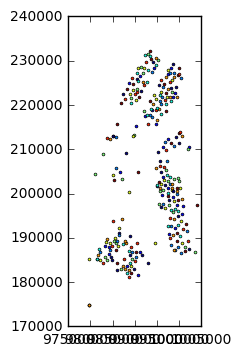

In [30]:
citi_stations_new = citi_stations_new.merge(citi_demo, left_on = 'station_id', right_index = True)
citi_stations_new.plot()

## add distance to subway

In [31]:
# combine lat and lon to one column
# Create Point Geometry for based on lonlat column
subway['lonlat']=zip(subway['Station Longitude'], subway['Station Latitude'])
subway['geometry']=subway[['lonlat']].applymap(lambda x:shp.geometry.Point(x))
subway = gp.GeoDataFrame(subway[['geometry']], geometry = 'geometry')

# handle coordinate system
subway.crs = {'init' :'epsg:4326'}
subway = subway.to_crs(epsg=2263)
subway.head()

,geometry
0,POINT (984779.6435399343 179876.8295590221)
1,POINT (984779.6435399343 179876.8295590221)
2,POINT (983265.2682330192 177963.0294655868)
3,POINT (983265.2682330192 177963.0294655868)
4,POINT (983265.2682330192 177963.0294655868)


In [32]:
# are citibikes near subway stations? near = within a quarter mile
a = []
b = []
citi_stations_new['subway_ct'] = 0
citi_stations_new['subway_dist'] = 0
for i in range(len(citi_stations_new)):
    # includes stations not in Manhattan, return 0 for CB. 
    b.append(subway.distance(citi_stations_new.iloc[i].geometry).min() / 5280)
    try: 
        a.append(len(subway[subway.geometry.intersects(citi_stations_new.iloc[i].geometry.buffer(5280/4))]))
    except: 
        a.append(0)
    print '\r',"%",str((i+1)*100./len(citi_stations_new))[:4],
citi_stations_new['subway_ct'] = a
citi_stations_new['subway_dist'] = b
citi_stations_new = citi_stations_new.reindex()

% 100.


In [33]:
# how dense are citibike stations? near = within a quarter mile
a = []
citi_stations_new['citi_ct'] = 0
for i in range(len(citi_stations_new)):
    # includes stations not in Manhattan, return 0 for CB. 
    try: 
        a.append(len(citi_stations_new[citi_stations_new.geometry.intersects(citi_stations_new.iloc[i].geometry.buffer(2 * 5280))]))
    except: 
        a.append(0)
    print '\r',"%",str((i+1)*100./len(citi_stations_new))[:4],
citi_stations_new['citi_ct'] = a
citi_stations_new = citi_stations_new.reindex()

% 100.


In [34]:
citi_stations_new.head()

,station_id,n_rides,geometry,tracts,bike,commute_time,dist_tohom,dist_towor,income_pc,no_vehicle_own,no_vehicle_rent,pop,workers,residents,subway_ct,subway_dist,citi_ct
0,3075,1639,POINT (995903.4755103544 196890.1444962268),"[360470535001000, 360470525001012, 36047052900...",7.75,512.5,2.741940,2.062547,10482.25,14.0,406.75,1877.0,85.982143,109.711310,10,0.088465,84
1,3133,1941,POINT (993984.1793322223 218842.3118619589),"[360610120001000, 360610120001001, 36061012000...",0.00,413.5,5.726791,2.390089,140649.00,252.0,128.00,1180.0,198.650000,118.800000,10,0.075666,102
2,3118,7029,POINT (997319.5902269882 207260.8096926071),"[360470575001000, 360470579002012, 36047057500...",11.50,273.0,5.019588,2.755904,27253.00,0.0,192.00,613.0,51.500000,111.555556,0,0.301732,68
3,3110,10684,POINT (997279.3509328024 204177.0295605607),"[360470561003000, 360470561003001, 36047056100...",12.00,610.0,4.849062,2.566536,39318.00,0.0,351.00,1070.0,101.500000,116.500000,6,0.191563,76
4,3093,24263,POINT (995751.5386958895 200666.2396872085),"[360470553001001, 360470553001002, 36047055300...",0.00,326.5,4.684627,2.710511,42034.50,0.0,225.00,674.0,116.125000,116.375000,4,0.086568,74


In [35]:
# export final data
citi_stations_new.drop('tracts',axis = 1, inplace = True)

if not os.path.exists('data/citi_stations_new/'):
    os.makedirs('data/citi_stations_new/')
    
citi_stations_new.to_file('data/citi_stations_new/citi_stations_new.shp')

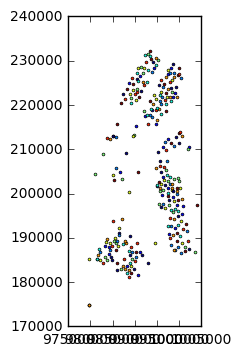

In [36]:
citi_stations_new.plot()